In [1]:
# Auto reload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
dataset_dir = '/mnt/pai_pdc_nas/data_waymo/processed_waymo_validation/processed'
ckpt_path = '/mnt/data/tianle_DPR/AAAI2025/train_DPR/DPR_20250620124629/epoch=01.ckpt'
anchor_path = '/mnt/data/tianle_DPR/AAAI2025/data/cluster_64_center_dict.pkl'

# Generating Traffic Scenarios with Goal Guidance
This notebook is a simple example of how to generate traffic scenarios that certain agents are conditioned with goals. In this example, goals are generated from a trajectory predicition model. In reality, goals can be obtained from other sources, such as human instructions, or planner.

In [ ]:
## Import Dependencies
import torch
import numpy as np
from DPR.model.utils import set_seed
set_seed(0)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

from waymax import dynamics
from waymax.config import EnvironmentConfig, ObjectType
from vbd.waymax_visualization.plotting import plot_state
from vbd.data.data_utils import data_process_scenario, tf_preprocess, tf_postprocess, data_collate_fn
from waymax import dataloader
from waymax.config import DataFormat
import mediapy
import pickle

MAX_NUM_OBJECTS = 32
MAX_POLYLINES = 256
NUM_POINTS_POLYLINE = 30


## Set Environment
env_config = EnvironmentConfig(
    # Ensure that the sim agent can control all valid objects.
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=11,
    max_num_objects=128,
)

from vbd.sim_agent.waymax_env import WaymaxEnvironment
from vbd.data.waymax_utils import smooth_scenario
dynamics_model = dynamics.StateDynamics()
env = WaymaxEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    log_replay = True,
)

# Create Dataset
from vbd.data.dataset import WaymaxTestDataset

dataset = WaymaxTestDataset(
    data_dir = dataset_dir,
    anchor_path = anchor_path,
    max_object=MAX_NUM_OBJECTS,
)
# Load model
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action
print('Load model', ckpt_path)
model = VBDTest.load_from_checkpoint(ckpt_path,map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()

model.reset_agent_length(MAX_NUM_OBJECTS)

Load model /mnt/data/tianle_DPR/AAAI2025/train_DPR/DPR_20250620124629/epoch=01.ckpt


RuntimeError: Error(s) in loading state_dict for VBDTest:
	Missing key(s) in state_dict: "denoiser.noise_level_embedding.weight", "denoiser.decoder.casual_mask", "denoiser.decoder.time", "denoiser.decoder.time_embedding.weight", "denoiser.decoder.attention_layers.0.cross_attention.in_proj_weight", "denoiser.decoder.attention_layers.0.cross_attention.in_proj_bias", "denoiser.decoder.attention_layers.0.cross_attention.out_proj.weight", "denoiser.decoder.attention_layers.0.cross_attention.out_proj.bias", "denoiser.decoder.attention_layers.0.norm_1.weight", "denoiser.decoder.attention_layers.0.norm_1.bias", "denoiser.decoder.attention_layers.0.norm_2.weight", "denoiser.decoder.attention_layers.0.norm_2.bias", "denoiser.decoder.attention_layers.0.ffn.0.weight", "denoiser.decoder.attention_layers.0.ffn.0.bias", "denoiser.decoder.attention_layers.0.ffn.3.weight", "denoiser.decoder.attention_layers.0.ffn.3.bias", "denoiser.decoder.attention_layers.1.cross_attention.in_proj_weight", "denoiser.decoder.attention_layers.1.cross_attention.in_proj_bias", "denoiser.decoder.attention_layers.1.cross_attention.out_proj.weight", "denoiser.decoder.attention_layers.1.cross_attention.out_proj.bias", "denoiser.decoder.attention_layers.1.norm_1.weight", "denoiser.decoder.attention_layers.1.norm_1.bias", "denoiser.decoder.attention_layers.1.norm_2.weight", "denoiser.decoder.attention_layers.1.norm_2.bias", "denoiser.decoder.attention_layers.1.ffn.0.weight", "denoiser.decoder.attention_layers.1.ffn.0.bias", "denoiser.decoder.attention_layers.1.ffn.3.weight", "denoiser.decoder.attention_layers.1.ffn.3.bias", "denoiser.decoder.attention_layers.2.cross_attention.in_proj_weight", "denoiser.decoder.attention_layers.2.cross_attention.in_proj_bias", "denoiser.decoder.attention_layers.2.cross_attention.out_proj.weight", "denoiser.decoder.attention_layers.2.cross_attention.out_proj.bias", "denoiser.decoder.attention_layers.2.norm_1.weight", "denoiser.decoder.attention_layers.2.norm_1.bias", "denoiser.decoder.attention_layers.2.norm_2.weight", "denoiser.decoder.attention_layers.2.norm_2.bias", "denoiser.decoder.attention_layers.2.ffn.0.weight", "denoiser.decoder.attention_layers.2.ffn.0.bias", "denoiser.decoder.attention_layers.2.ffn.3.weight", "denoiser.decoder.attention_layers.2.ffn.3.bias", "denoiser.decoder.attention_layers.3.cross_attention.in_proj_weight", "denoiser.decoder.attention_layers.3.cross_attention.in_proj_bias", "denoiser.decoder.attention_layers.3.cross_attention.out_proj.weight", "denoiser.decoder.attention_layers.3.cross_attention.out_proj.bias", "denoiser.decoder.attention_layers.3.norm_1.weight", "denoiser.decoder.attention_layers.3.norm_1.bias", "denoiser.decoder.attention_layers.3.norm_2.weight", "denoiser.decoder.attention_layers.3.norm_2.bias", "denoiser.decoder.attention_layers.3.ffn.0.weight", "denoiser.decoder.attention_layers.3.ffn.0.bias", "denoiser.decoder.attention_layers.3.ffn.3.weight", "denoiser.decoder.attention_layers.3.ffn.3.bias", "denoiser.decoder.encoder.0.weight", "denoiser.decoder.encoder.0.bias", "denoiser.decoder.encoder.2.weight", "denoiser.decoder.encoder.2.bias", "denoiser.decoder.decoder.0.weight", "denoiser.decoder.decoder.0.bias", "denoiser.decoder.decoder.3.weight", "denoiser.decoder.decoder.3.bias". 
	Unexpected key(s) in state_dict: "denoiser.dit.route_encoder.anchor_mlp.0.weight", "denoiser.dit.route_encoder.anchor_mlp.0.bias", "denoiser.dit.route_encoder.anchor_mlp.2.weight", "denoiser.dit.route_encoder.anchor_mlp.2.bias", "denoiser.dit.route_encoder.traj_mlp.0.weight", "denoiser.dit.route_encoder.traj_mlp.0.bias", "denoiser.dit.route_encoder.traj_mlp.2.weight", "denoiser.dit.route_encoder.traj_mlp.2.bias", "denoiser.dit.route_encoder.fusion_mlp.0.weight", "denoiser.dit.route_encoder.fusion_mlp.0.bias", "denoiser.dit.route_encoder.fusion_mlp.2.weight", "denoiser.dit.route_encoder.fusion_mlp.2.bias", "denoiser.dit.agent_embedding.weight", "denoiser.dit.preproj.fc1.weight", "denoiser.dit.preproj.fc1.bias", "denoiser.dit.preproj.fc2.weight", "denoiser.dit.preproj.fc2.bias", "denoiser.dit.t_embedder.mlp.0.weight", "denoiser.dit.t_embedder.mlp.0.bias", "denoiser.dit.t_embedder.mlp.2.weight", "denoiser.dit.t_embedder.mlp.2.bias", "denoiser.dit.blocks.0.norm1.weight", "denoiser.dit.blocks.0.norm1.bias", "denoiser.dit.blocks.0.attn.in_proj_weight", "denoiser.dit.blocks.0.attn.in_proj_bias", "denoiser.dit.blocks.0.attn.out_proj.weight", "denoiser.dit.blocks.0.attn.out_proj.bias", "denoiser.dit.blocks.0.norm2.weight", "denoiser.dit.blocks.0.norm2.bias", "denoiser.dit.blocks.0.mlp1.fc1.weight", "denoiser.dit.blocks.0.mlp1.fc1.bias", "denoiser.dit.blocks.0.mlp1.fc2.weight", "denoiser.dit.blocks.0.mlp1.fc2.bias", "denoiser.dit.blocks.0.adaLN_modulation.1.weight", "denoiser.dit.blocks.0.adaLN_modulation.1.bias", "denoiser.dit.blocks.0.norm3.weight", "denoiser.dit.blocks.0.norm3.bias", "denoiser.dit.blocks.0.cross_attn.in_proj_weight", "denoiser.dit.blocks.0.cross_attn.in_proj_bias", "denoiser.dit.blocks.0.cross_attn.out_proj.weight", "denoiser.dit.blocks.0.cross_attn.out_proj.bias", "denoiser.dit.blocks.0.norm4.weight", "denoiser.dit.blocks.0.norm4.bias", "denoiser.dit.blocks.0.mlp2.fc1.weight", "denoiser.dit.blocks.0.mlp2.fc1.bias", "denoiser.dit.blocks.0.mlp2.fc2.weight", "denoiser.dit.blocks.0.mlp2.fc2.bias", "denoiser.dit.blocks.1.norm1.weight", "denoiser.dit.blocks.1.norm1.bias", "denoiser.dit.blocks.1.attn.in_proj_weight", "denoiser.dit.blocks.1.attn.in_proj_bias", "denoiser.dit.blocks.1.attn.out_proj.weight", "denoiser.dit.blocks.1.attn.out_proj.bias", "denoiser.dit.blocks.1.norm2.weight", "denoiser.dit.blocks.1.norm2.bias", "denoiser.dit.blocks.1.mlp1.fc1.weight", "denoiser.dit.blocks.1.mlp1.fc1.bias", "denoiser.dit.blocks.1.mlp1.fc2.weight", "denoiser.dit.blocks.1.mlp1.fc2.bias", "denoiser.dit.blocks.1.adaLN_modulation.1.weight", "denoiser.dit.blocks.1.adaLN_modulation.1.bias", "denoiser.dit.blocks.1.norm3.weight", "denoiser.dit.blocks.1.norm3.bias", "denoiser.dit.blocks.1.cross_attn.in_proj_weight", "denoiser.dit.blocks.1.cross_attn.in_proj_bias", "denoiser.dit.blocks.1.cross_attn.out_proj.weight", "denoiser.dit.blocks.1.cross_attn.out_proj.bias", "denoiser.dit.blocks.1.norm4.weight", "denoiser.dit.blocks.1.norm4.bias", "denoiser.dit.blocks.1.mlp2.fc1.weight", "denoiser.dit.blocks.1.mlp2.fc1.bias", "denoiser.dit.blocks.1.mlp2.fc2.weight", "denoiser.dit.blocks.1.mlp2.fc2.bias", "denoiser.dit.blocks.2.norm1.weight", "denoiser.dit.blocks.2.norm1.bias", "denoiser.dit.blocks.2.attn.in_proj_weight", "denoiser.dit.blocks.2.attn.in_proj_bias", "denoiser.dit.blocks.2.attn.out_proj.weight", "denoiser.dit.blocks.2.attn.out_proj.bias", "denoiser.dit.blocks.2.norm2.weight", "denoiser.dit.blocks.2.norm2.bias", "denoiser.dit.blocks.2.mlp1.fc1.weight", "denoiser.dit.blocks.2.mlp1.fc1.bias", "denoiser.dit.blocks.2.mlp1.fc2.weight", "denoiser.dit.blocks.2.mlp1.fc2.bias", "denoiser.dit.blocks.2.adaLN_modulation.1.weight", "denoiser.dit.blocks.2.adaLN_modulation.1.bias", "denoiser.dit.blocks.2.norm3.weight", "denoiser.dit.blocks.2.norm3.bias", "denoiser.dit.blocks.2.cross_attn.in_proj_weight", "denoiser.dit.blocks.2.cross_attn.in_proj_bias", "denoiser.dit.blocks.2.cross_attn.out_proj.weight", "denoiser.dit.blocks.2.cross_attn.out_proj.bias", "denoiser.dit.blocks.2.norm4.weight", "denoiser.dit.blocks.2.norm4.bias", "denoiser.dit.blocks.2.mlp2.fc1.weight", "denoiser.dit.blocks.2.mlp2.fc1.bias", "denoiser.dit.blocks.2.mlp2.fc2.weight", "denoiser.dit.blocks.2.mlp2.fc2.bias", "denoiser.dit.blocks.3.norm1.weight", "denoiser.dit.blocks.3.norm1.bias", "denoiser.dit.blocks.3.attn.in_proj_weight", "denoiser.dit.blocks.3.attn.in_proj_bias", "denoiser.dit.blocks.3.attn.out_proj.weight", "denoiser.dit.blocks.3.attn.out_proj.bias", "denoiser.dit.blocks.3.norm2.weight", "denoiser.dit.blocks.3.norm2.bias", "denoiser.dit.blocks.3.mlp1.fc1.weight", "denoiser.dit.blocks.3.mlp1.fc1.bias", "denoiser.dit.blocks.3.mlp1.fc2.weight", "denoiser.dit.blocks.3.mlp1.fc2.bias", "denoiser.dit.blocks.3.adaLN_modulation.1.weight", "denoiser.dit.blocks.3.adaLN_modulation.1.bias", "denoiser.dit.blocks.3.norm3.weight", "denoiser.dit.blocks.3.norm3.bias", "denoiser.dit.blocks.3.cross_attn.in_proj_weight", "denoiser.dit.blocks.3.cross_attn.in_proj_bias", "denoiser.dit.blocks.3.cross_attn.out_proj.weight", "denoiser.dit.blocks.3.cross_attn.out_proj.bias", "denoiser.dit.blocks.3.norm4.weight", "denoiser.dit.blocks.3.norm4.bias", "denoiser.dit.blocks.3.mlp2.fc1.weight", "denoiser.dit.blocks.3.mlp2.fc1.bias", "denoiser.dit.blocks.3.mlp2.fc2.weight", "denoiser.dit.blocks.3.mlp2.fc2.bias", "denoiser.dit.final_layer.norm_final.weight", "denoiser.dit.final_layer.norm_final.bias", "denoiser.dit.final_layer.proj.0.weight", "denoiser.dit.final_layer.proj.0.bias", "denoiser.dit.final_layer.proj.1.weight", "denoiser.dit.final_layer.proj.1.bias", "denoiser.dit.final_layer.proj.3.weight", "denoiser.dit.final_layer.proj.3.bias", "denoiser.dit.final_layer.proj.4.weight", "denoiser.dit.final_layer.proj.4.bias", "denoiser.dit.final_layer.adaLN_modulation.1.weight", "denoiser.dit.final_layer.adaLN_modulation.1.bias". 
	size mismatch for predictor.act_decoder.3.weight: copying a param with shape torch.Size([80, 256]) from checkpoint, the shape in current model is torch.Size([40, 256]).
	size mismatch for predictor.act_decoder.3.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([40]).

In [23]:
def plot_results(init_state, is_controlled, denoiser_output, h=-1, t=-1, video = False, **kwargs):
    if 'history' in denoiser_output:
        # traj_input = denoiser_output['history']['denoiser_output_history']['noised_trajs'][h, 0, ...]
        traj_pred = denoiser_output['history']['denoiser_output_history']['denoised_trajs'][h, 0, ...] # [A,T,D]
    else:
        # traj_input = denoiser_output['noised_trajs'][0, ...].detach().cpu().numpy()
        traj_pred = denoiser_output['denoised_trajs'][0, ...].detach().cpu().numpy()
    
    state_logs = [init_state]
    current_state = init_state
    for i in range(init_state.remaining_timesteps):
        action_sample = traj_pred[:, i, :]
        action = sample_to_action(action_sample, is_controlled)
        current_state = env.step_sim_agent(current_state, [action])
        state_logs.append(current_state)

    mediapy.show_image(plot_state(state_logs[t], **kwargs))

## Load one scenario and visualize the log replay


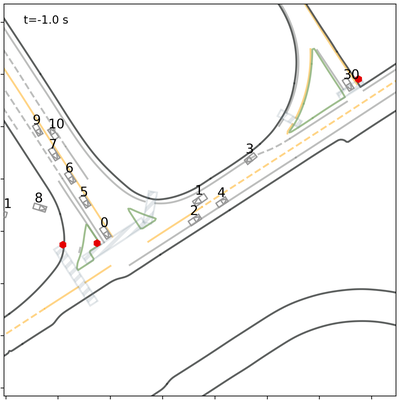

In [24]:
scenario_id, scenario, _ = dataset.get_scenario_by_id('4aaed6b2e4ce00dc')

scenario.sim_trajectory = scenario.log_trajectory
mediapy.show_image(plot_state(scenario))

## Open-loop Roll Out without Goal Guidance

In [25]:
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Reset the environment
init_state = env.reset(scenario)

current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Update object meta data
print(selected_agents)

state_logs = [current_state]

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=False,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    action_sample = traj_pred[:, t, :]
    action = sample_to_action(action_sample, is_controlled, agents_id=selected_agents)
    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)

/home/zixuzhang/Documents/Git/diffusion_waymax/vbd/data/data_utils.py:294: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  agents_history[i][~log_trajectory.valid[a, :current_index+1]] = 0


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Replan at  10


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 34.19it/s]


In [26]:
imgs = [plot_state(state) for state in state_logs]
mediapy.show_video(imgs, fps=10)

## Roll Out with Goal Guidance

In [23]:
from vbd.sim_agent.guidance_metrics import TrackingReward
model.early_stop = 0 # Stop Diffusion Early From 100 to X

model.skip = 1 # Skip Alpha 
model.cuda()
model.reward_func = torch.nn.ModuleList([
    TrackingReward(),
])
model.guidance_iter = 10
model.guidance_start = 50
model.guidance_end = 1
model.gradient_scale = 0.5
model.scale_grad_by_std = False
model.guidance_func = model.guidance

init_state = env.reset(scenario)
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested']>0
selected_agents = sample['agents_id'][is_controlled]

# Assign goals as reference
ref = np.zeros((1,dataset.max_object,80,2))
ref[0,5,:,:] = np.array([5900, -3123])
ref = torch.from_numpy(ref).to(model.device)

weight = torch.zeros((1,dataset.max_object,80)).to(model.device)
weight[0,5,-1] = 1.0 # we only care about agent 5

# Generate a sample
state_logs = [current_state]

batch = dataset.__collate_fn__([sample])
pred = model.sample_denoiser(batch, traj_ref=ref, weight=weight)
traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

for t in range(current_state.remaining_timesteps):
    action_sample = traj_pred[:, t, :]
    action = sample_to_action(action_sample, is_controlled, agents_id=selected_agents)
    current_state = env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)


Diffusion: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


In [24]:
from vbd.waymax_visualization.utils import img_from_fig

goal = ref[0,5,-1,:].cpu().numpy()

imgs = []
for state in state_logs:
    fig, ax = plot_state(state, return_ax=True)
    ax.scatter(goal[0], goal[1], color='red', marker='x')
    imgs.append(mediapy.resize_image(img_from_fig(fig), (400, 400)))
                
mediapy.show_video(imgs, fps=10)